In [58]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.data_loader import Dataset_Huawei
from models.seqformer.seqformer import series_decomp

In [25]:
# 预设值
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None  # 展示所有列

config = {
    "font.family": 'serif',
    "font.size": 20,
    "mathtext.fontset": 'stix',
    "font.serif": ['Times New Roman'],
    "font.weight": "normal"
}
rcParams.update(config)
chinese_font = {
    'family': 'SimSun',
    'size': 20,
    'weight': 'normal',
}

In [26]:
data_path = '../datasets/huawei/data.csv'
data_df = pd.read_csv(data_path)
print(data_df.describe())

              API_ID    time_period            day           hour  \
count  299520.000000  299520.000000  299520.000000  299520.000000   
mean       94.600000    9132.423077      31.211538      11.500000   
std        46.671697    5408.237544      18.776384       6.922198   
min        27.000000       0.000000       0.000000       0.000000   
25%        63.750000    3743.750000      12.750000       5.750000   
50%        90.500000   10079.500000      34.500000      11.500000   
75%       147.750000   13823.250000      47.250000      17.250000   
max       165.000000   17567.000000      60.000000      23.000000   

              minute          time  requests_minute  memory_usage_minute  \
count  299520.000000  2.995200e+05     2.995200e+05        299520.000000   
mean       31.500000  2.739967e+06     1.108282e+05             0.205279   
std        17.260291  1.622471e+06     1.994497e+05             0.164046   
min         4.000000  2.400000e+02     0.000000e+00             0.000000  

In [48]:
class Config:
    # basic config
    model_name = 'dsformer'  # 模型名称
    save_path = '../checkpoints/huawei/{}.pth'.format(model_name)  # 最优模型保存路径

    # data loader
    data_path = '../datasets/huawei/data.csv'
    features = 'MS'  # 三个选项M，MS，S。分别是多元预测多元，多元预测单元，单元预测单元
    target = 'total_cpu_usage'  # 预测目标
    checkpoints = './checkpoints'
    scale_type = 'standard'  # 标准化类型 "standard" "minmax"

    # forecasting task
    timestep = 250  # 时间步长，就是利用多少时间窗口
    output_size = 18  # 只预测CPU
    feature_size = 18  # 每个步长对应的特征数量（跟数据集处理有关，我只保留了七个特征）
    pre_len = 250  # 预测长度
    inverse = False

    # model define
    hidden_size = 128  # 隐层大小
    enc_layers = 1
    ffn_hidden_size = 1024  # FFN隐层大小
    num_heads = 2
    dropout = 0.1
    use_RevIN = True
    conv = True
    factor = 1
    activation = 'gelu'
    moving_avg = 25
    dec_type = 'linear'  # 解码器类型 ['mlp', 'linear']

    # optimization
    epochs = 100  # 迭代轮数
    batch_size = 256  # 批次大小
    patience = 5  # 早停机制，如果损失多少个epochs没有改变就停止训练。
    learning_rate = 0.001  # 学习率
    loss_name = 'MSE'  # 损失函数名称 ['MSE', 'MAPE', 'MASE', 'SMAPE', 'smoothl1']
    lradj = 'cosine'  # 学习率的调整方式 ['type1', 'type2', 'cosine']

    # GPU
    use_gpu = True
    gpu = 0

    pred_mode = 'paper'  # 预测模式 ['paper', 'show']
    test_show = 'brief'  # 测试集展示 ['all', 'brief']


args = Config()
test_data_set = Dataset_Huawei(
    args=args,
    data_path=args.data_path,
    flag="test",
    size=[args.timestep, args.feature_size, args.pre_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
)

加载test数据集...
数据集shape: (299520, 20)


100%|██████████| 20/20 [00:01<00:00, 19.71it/s]


test数据集大小：(30340, 250, 18)
test标签大小：(30340, 250, 1)


In [49]:
test_loader = DataLoader(test_data_set,
                         args.batch_size,
                         shuffle=False)

  0%|          | 0/119 [00:00<?, ?it/s]

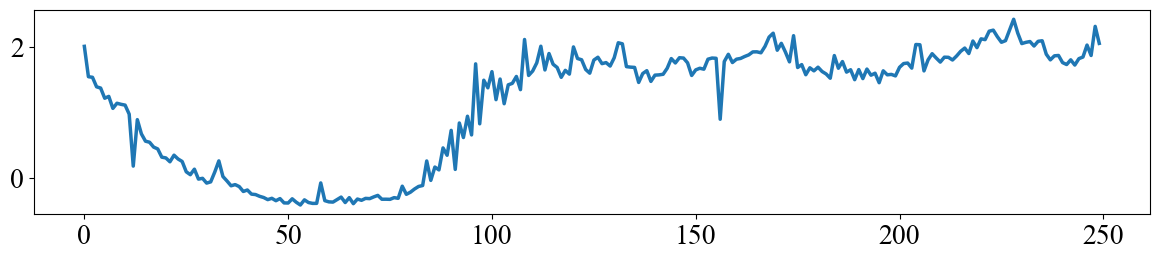

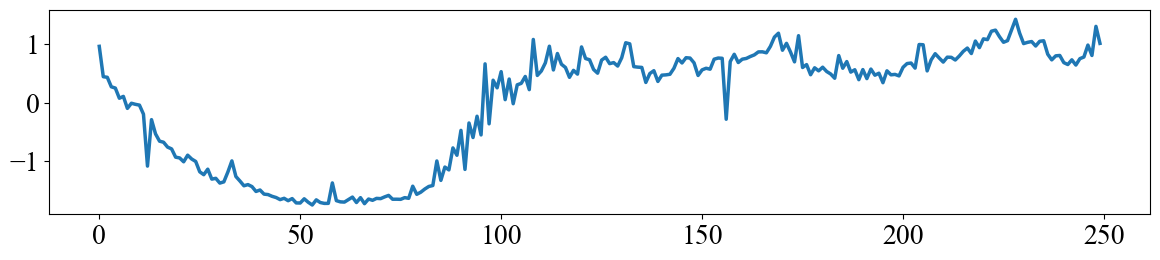

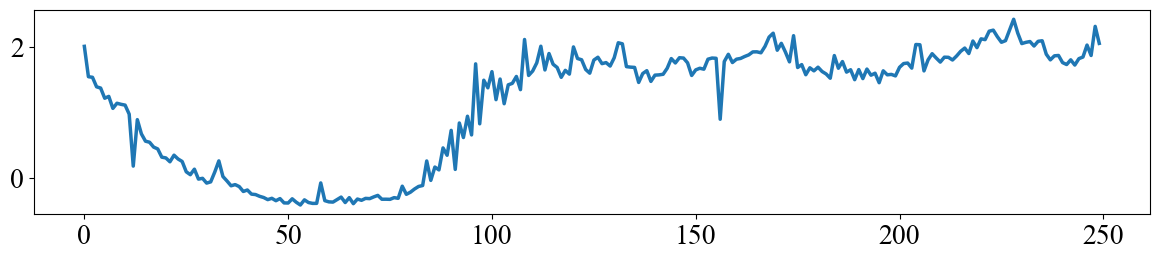

  0%|          | 0/119 [00:00<?, ?it/s]


In [64]:
from models.RevIN.RevIN import RevIN

revin = RevIN(args.feature_size)

for i, (batch_x, batch_y, batch_idx) in enumerate(tqdm(test_loader)):
    plt.figure(figsize=(12, 3))
    plt.plot(batch_x.detach().numpy()[0, :, 0], linewidth=2.5, label='原始')
    # plt.legend(prop=chinese_font, loc='upper left')
    plt.tight_layout()
    # plt.savefig('./paper_img/origin.png', dpi=400, bbox_inches='tight')
    plt.show()

    batch_x = revin(batch_x, 'norm')

    plt.figure(figsize=(12, 3))
    plt.plot(batch_x.detach().numpy()[0, :, 0], linewidth=2.5, label='归一化')
    # plt.legend(prop=chinese_font, loc='upper left')
    plt.tight_layout()
    # plt.savefig('./paper_img/origin.png', dpi=400, bbox_inches='tight')
    plt.show()

    
    output = revin(batch_x, 'denorm')
    plt.figure(figsize=(12, 3))
    plt.plot(output.detach().numpy()[0, :, 0], linewidth=2.5, label='逆归一化')
    # plt.legend(prop=chinese_font, loc='upper left')
    plt.tight_layout()
    # plt.savefig('./paper_img/origin.png', dpi=400, bbox_inches='tight')
    plt.show()


    break

  0%|          | 0/119 [00:00<?, ?it/s]

torch.Size([256, 250, 18])
torch.Size([256, 250, 18])


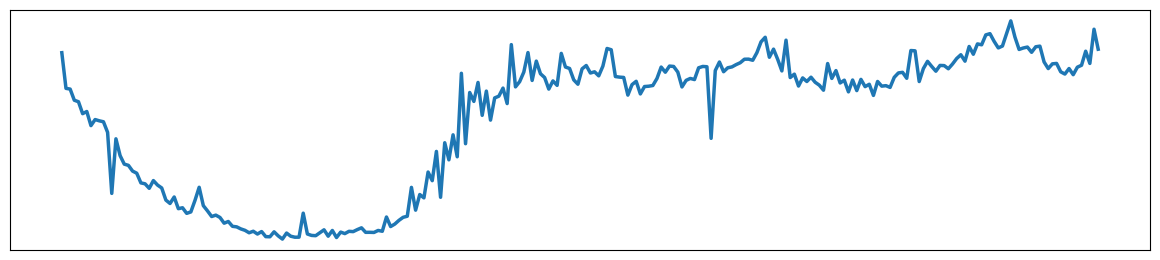

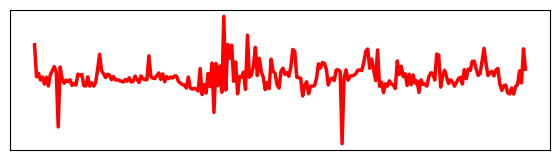

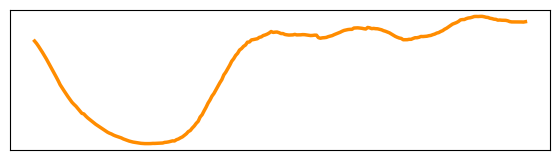

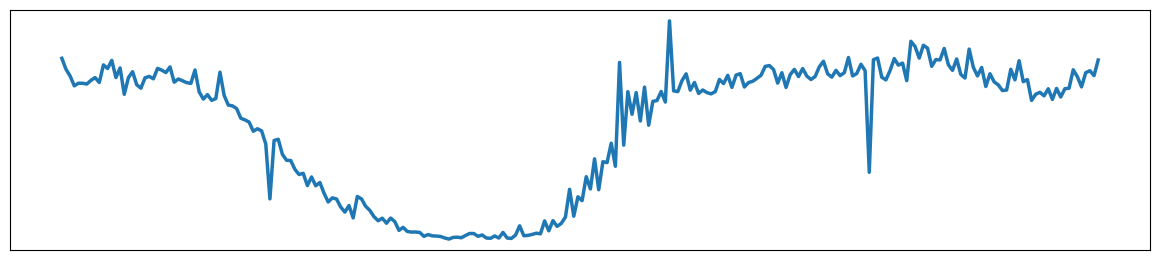

  0%|          | 0/119 [00:00<?, ?it/s]


In [60]:
moving_avg = 25
decompsition = series_decomp(moving_avg)

for i, (batch_x, batch_y, batch_idx) in enumerate(tqdm(test_loader)):
    seasonal_init, trend_init = decompsition(batch_x)
    print(seasonal_init.shape)
    print(trend_init.shape)

    # 取seasonal_init第一列绘制时序图

    plt.figure(figsize=(12, 3))
    plt.plot(batch_x[0, :, 0], linewidth=2.5, label='原始')
    # plt.legend(prop=chinese_font, loc='upper left')
    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    frame.axes.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('./paper_img/origin.png', dpi=400, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.plot(seasonal_init[0, :, 0], linewidth=2.5, label='剩余', color='red')
    # plt.legend(prop=chinese_font, loc='upper left')
    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    frame.axes.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('./paper_img/remainder.png', dpi=400, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.plot(trend_init[0, :, 0], linewidth=2.5, label='趋势', color='darkorange')
    # plt.legend(prop=chinese_font, loc='upper left')
    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    frame.axes.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('./paper_img/trend.png', dpi=400, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(batch_y[0, :, 0], linewidth=2.5, label='预测')
    # plt.legend(prop=chinese_font, loc='upper left')
    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)
    # x 轴不可见
    frame.axes.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig('./paper_img/pred.png', dpi=400, bbox_inches='tight')
    plt.show()
    break